Credits: Johannes Rieke

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
n_imgs = 50000
size_img = 8
min_size_object = 1
max_size_object = 4
n_objects = 1

In [3]:
bboxes = np.zeros((n_imgs, n_objects, 4))
imgs = np.zeros((n_imgs, size_img, size_img))

In [4]:
for i in range(n_imgs):
    for o in range(n_objects):
        w, h = np.random.randint(min_size_object,
                                 max_size_object, size=2)
        x = np.random.randint(0, size_img - w)
        y = np.random.randint(0, size_img - h)
        imgs[i, x:x+w, y:y+h] = 255
        bboxes[i, o] = [x, y, w, h]
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 1, 4))

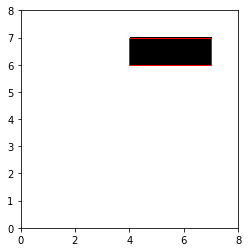

In [5]:
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none',
           origin='lower', extent=[0, size_img, 0, size_img])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

In [6]:
X = imgs.reshape((n_imgs, -1))
X = X.astype('float32') / 255

y = bboxes.reshape((n_imgs, -1))
y = y.astype('float32') / size_img
X.shape, y.shape

((50000, 64), (50000, 4))

In [7]:
i = int(0.8 * n_imgs)
X_train = X[:i]
X_test = X[i:]
y_train = y[:i]
y_test = y[i:]

test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam

Using TensorFlow backend.


In [9]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X.shape[-1], ))) 
model.add(Dropout(0.2))
model.add(Dense(y.shape[-1]))
print(model.summary())

model.compile(optimizer=Adam(lr=0.0001), loss='mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               33280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 35,332
Trainable params: 35,332
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    verbose=2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
3s - loss: 0.0359 - val_loss: 0.0101
Epoch 2/30
0s - loss: 0.0098 - val_loss: 0.0042
Epoch 3/30
0s - loss: 0.0059 - val_loss: 0.0022
Epoch 4/30
0s - loss: 0.0043 - val_loss: 0.0013
Epoch 5/30
0s - loss: 0.0034 - val_loss: 8.5386e-04
Epoch 6/30
0s - loss: 0.0027 - val_loss: 6.1382e-04
Epoch 7/30
0s - loss: 0.0023 - val_loss: 4.5784e-04
Epoch 8/30
0s - loss: 0.0019 - val_loss: 3.4208e-04
Epoch 9/30
0s - loss: 0.0017 - val_loss: 2.6380e-04
Epoch 10/30
0s - loss: 0.0015 - val_loss: 2.0771e-04
Epoch 11/30
0s - loss: 0.0013 - val_loss: 1.6295e-04
Epoch 12/30
0s - loss: 0.0011 - val_loss: 1.3012e-04
Epoch 13/30
0s - loss: 0.0010 - val_loss: 1.0476e-04
Epoch 14/30
0s - loss: 9.4507e-04 - val_loss: 8.8894e-05
Epoch 15/30
0s - loss: 8.5833e-04 - val_loss: 7.0377e-05
Epoch 16/30
0s - loss: 7.8299e-04 - val_loss: 5.9418e-05
Epoch 17/30
0s - loss: 7.3016e-04 - val_loss: 4.7371e-05
Epoch 18/30
0s - loss: 6.7690e-04 - val_loss: 4.3849e-05
E

In [11]:
pred_y = model.predict(X_test)
pred_bboxes = pred_y * size_img
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), n_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [12]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    
    else:
        I = w_I * h_I
        U = w1 * h1 + w2 * h2 - I
        return I / U

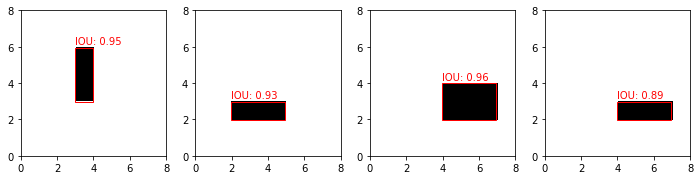

In [13]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, size_img, 0, size_img])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
        
# plt.savefig('plots/bw-single-rectangle_prediction.png', dpi=300)

In [14]:
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.92741921771512914